# Area sampling using Dask and Xarray
Computational improvement based on test_area_sample_PETandLtheta.ipynb

In [1]:
from dask.distributed import Client
import xarray as xr
import numpy as np
from datetime import datetime
import os
import rasterio as rio
import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from osgeo import gdal
import cartopy.crs as ccrs

In [2]:
###### Define constants ###########

# Changable

plot_results = True

# Area
network_name = "California"
minx = -124.5
miny = 32.5
maxx = -114
maxy = 42.5
bbox = {'minx':minx, 'maxx':maxx, 'miny':miny, 'maxy':maxy}

# Chunks
chunks = {'x': 100, 'y': 100}
pet_chunks = {'longitude': 100, 'latitude': 100}

# Thresholds
lower_quantile_thresh = 0.25
upper_quantile_thresh = 0.75
precip_thresh = 0.00002

# Dates
startDate = datetime(2016, 1, 1)
endDate = datetime(2017, 1, 1)

# Non-changable
SMAPL4_times = ['0130', '0430', '0730', '1030', '1330', '1630', '1930', '2230'] # 3-hourly data

###### PATH ###########
input_path = r"..\1_data"
output_path = r"..\3_data_out"
SMAPL3_path = "SPL3SMP_E"
SMAPL4_path = "SPL4SMGP"
SMAPL4_grid_path = "SMAPL4SMGP_EASEreference"
PET_path = "PET"

In [3]:
client = Client(n_workers=10, threads_per_worker=5, memory_limit='16GB')
client
# See https://distributed.dask.org/en/stable/client.html

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 50,Total memory: 149.01 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56651,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 50
Started: Just now,Total memory: 149.01 GiB
Comm: tcp://127.0.0.1:56697,Total threads: 5
Dashboard: http://127.0.0.1:56698/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:56654,


## Read data 

### Read SMAP L4 data

In [4]:
def _preprocess_SMAPL4(ds):
    # Assign missing time dimension
    startTime = datetime.strptime(ds.rangeBeginningDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    endTime = datetime.strptime(ds.rangeEndingDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    midTime = startTime + (startTime - endTime)/2
    ds = ds.assign_coords(time=midTime)
    return ds

In [5]:
# Get a list of files 

SMAPL4_fn_pattern = f'SMAP_L4_SM_gph_{startDate.year}010*.nc' ####### CHNAGE LATER: testing with 2016 Jan 1-9 data ####### 
SMAPL4_file_paths = glob.glob(rf'{input_path}/{SMAPL4_path}/{SMAPL4_fn_pattern}')

# Load data
ds_SMAPL4_3hrly = xr.open_mfdataset(SMAPL4_file_paths, group='Geophysical_Data', engine="rasterio", preprocess=_preprocess_SMAPL4, chunks=chunks, combine='nested', concat_dim='time', parallel=True)

# TODO/IMPROVEMENT #3: open_mfdataset(parallel=True) is not really making things super fast. Need to otimize Clients

# # https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html#xarray.open_mfdataset

In [6]:
# Re-assign x and y coordinates
SMAPL4_template_fn = r"G:\Araki\SMSigxSMAP\1_data\SPL4SMGP\SMAP_L4_SM_gph_20180911T103000_Vv7032_001_HEGOUT.nc"
SMAPL4_template = xr.open_dataset(SMAPL4_template_fn)
ds_SMAPL4_3hrly = ds_SMAPL4_3hrly.assign_coords(x=SMAPL4_template['x'][:], y=SMAPL4_template['y'][:]*(-1))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# ds_SMAPL4.precipitation_total_surface_flux.sel(time='2016-01-01 01:30:00').plot(ax=ax)
# ds_SMAPL4.precipitation_total_surface_flux

<xarray.Dataset>
Dimensions:                           (band: 1, x: 113, y: 107, time: 72)
Coordinates:
  * band                              (band) int32 1
  * x                                 (x) float64 -124.5 -124.4 ... -114.0
  * y                                 (y) float64 32.54 32.64 ... 42.35 42.44
    projection_information            int32 0
  * time                              (time) datetime64[ns] 2015-12-31T22:30:...
Data variables:
    precipitation_total_surface_flux  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 41, 6), meta=np.ndarray>
Attributes: (12/201)
    antennaRotationRate:                13
    description:                        The observation-corrected surface met...
    identifier:                         GEOS5COR
    edition:                            JPL CL#14-2285, JPL 400-1567
    publicationDate:                    2014-07-01
    title:                              SMAP Handbook
    ...                                 ...
    grid_rows:                          1822
    History:                            File written by ldas2daac.x
    Institution:                        NASA Global Modeling and Assimilation...
    References:                         see SMAP L4_SM Product Specification ...
    Source:                             v17.11.1
    Title:                              SMAP L4_SM Geophysical (GPH) Data Gra...

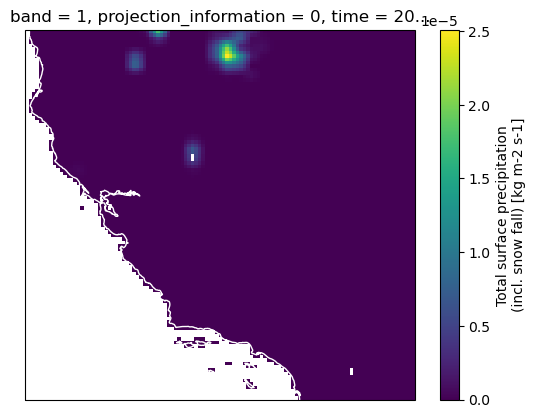

In [7]:
ds_SMAPL4_3hrly = ds_SMAPL4_3hrly.sel(x=slice(minx, maxx), y=slice(miny, maxy))

if plot_results:
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(color='white')
    ds_SMAPL4_3hrly.sel(time='2016-01-01 01:30:00').precipitation_total_surface_flux.plot(ax=ax)
    ds_SMAPL4_3hrly

### Read SMAP L3 data

In [8]:
def _preprocess_SMAPL3(ds):
    # Assign missing time dimension
    # Doesn't care about hour amd minutes, as it is daily data
    startTime = datetime.strptime(ds.rangeBeginningDateTime.split("T")[0], '%Y-%m-%d')
    ds = ds.assign_coords(time=startTime)
    return ds

In [9]:
# Get a list of files 
# Test with 2016 Jan 1-9 data first
SMAPL3_fn_pattern = f'SMAP_L3_SM_P_E_{startDate.year}010*.nc' ####### CHNAGE LATER: testing with 2016 Jan 1-9 data #######
SMAPL3_file_paths = glob.glob(rf'{input_path}/{SMAPL3_path}/{SMAPL3_fn_pattern}')
# Load data
ds_SMAPL3 = xr.open_mfdataset(SMAPL3_file_paths, preprocess=_preprocess_SMAPL3, engine="rasterio", chunks=chunks, combine="nested", concat_dim="time", parallel=True)

In [18]:
ds_SMAPL3 = ds_SMAPL3.sel(x=slice(minx, maxx), y=slice(maxy, miny))
ds_SMAPL3.rio.write_crs('epsg:4326')
ds_SMAPL3
# 3.3 sec for 1 mo of data

<xarray.Dataset>
Dimensions:                  (band: 1, x: 113, y: 107, time: 9)
Coordinates:
  * band                     (band) int32 1
  * x                        (x) float64 -124.5 -124.4 -124.3 ... -114.1 -114.0
  * y                        (y) float64 42.43 42.33 42.24 ... 32.72 32.62 32.53
    /crs                     int32 0
  * time                     (time) datetime64[ns] 2016-01-01 ... 2016-01-09
Data variables: (12/15)
    EASE_column_index        (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    longitude_pm             (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    retrieval_qual_flag_pm   (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    soil_moisture_pm         (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    EASE_row_index           (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    latitude                 (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    ...                       ...
    EASE_column_index_pm     (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    EASE_row_index_pm        (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    latitude_pm              (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    soil_moisture_am_masked  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    soil_moisture_pm_masked  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    soil_moisture_daily      (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
Attributes: (12/82)
    antennaRotationRate:                  14.6
    description:                          A configuration file generated auto...
    identifier:                           L3_SM_P_E_SPS
    edition:                              1.0
    publicationDate:                      2013-02-08
    title:                                Product Specification Document for ...
    ...                                   ...
    identifier_product_DOI:               doi:10.5067/4DQ54OUIJ9DL
    longName:                             SMAP Enhanced L3 Radiometer Global ...
    mission:                              SMAP
    pointOfContact:                       National Snow and Ice Data Center
    resourceProviderOrganizationName:     National Aeronautics and Space Admi...
    revisionDate:                         2021-08-31

<xarray.DataArray 'soil_moisture' (time: 9, band: 1, y: 107, x: 113)>
dask.array<getitem, shape=(9, 1, 107, 113), dtype=float32, chunksize=(1, 1, 63, 100), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int32 1
  * x        (x) float64 -124.5 -124.4 -124.3 -124.2 ... -114.2 -114.1 -114.0
  * y        (y) float64 42.43 42.33 42.24 42.15 ... 32.81 32.72 32.62 32.53
    /crs     int32 0
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-01-09
Attributes: (12/32)
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#coordinates:       /Soil_M...
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#DIMENSION_LABELS:  {y,x}
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#grid_mapping:      /crs
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#long_name:         Represe...
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#units:             cm**3/c...
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#valid_max:         0.5
    ...                                                               ...
    coordinates:                                                      /Soil_M...
    DIMENSION_LABELS:                                                 {y,x}
    long_name:                                                        Represe...
    units:                                                            cm**3/c...
    valid_max:                                                        0.5
    valid_min:                                                        0.02

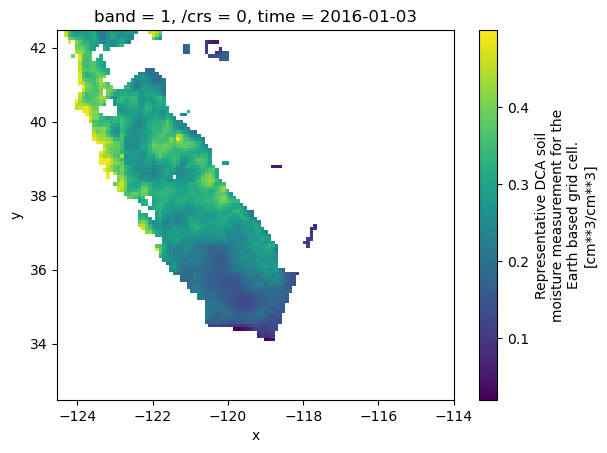

In [11]:
ds_SMAPL3.sel(time='2016-01-03').soil_moisture.plot()
ds_SMAPL3.soil_moisture
# TODO/IMPROVEMENT: Add dropna(how=all) somewhere to skip calculation of the ocean etc.

### Read Singer PET data

In [12]:
# Get a list of files 
PET_fn_pattern = f'*_daily_pet.nc'
PET_file_paths = glob.glob(rf'{input_path}/{PET_path}/{PET_fn_pattern}')

# Load data
ds_PET = xr.open_mfdataset(PET_file_paths, combine="nested", chunks=pet_chunks, concat_dim="time", parallel=True)
ds_PET['pet']

<xarray.DataArray 'pet' (time: 2557, latitude: 1801, longitude: 3600)>
dask.array<concatenate, shape=(2557, 1801, 3600), dtype=float32, chunksize=(366, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9

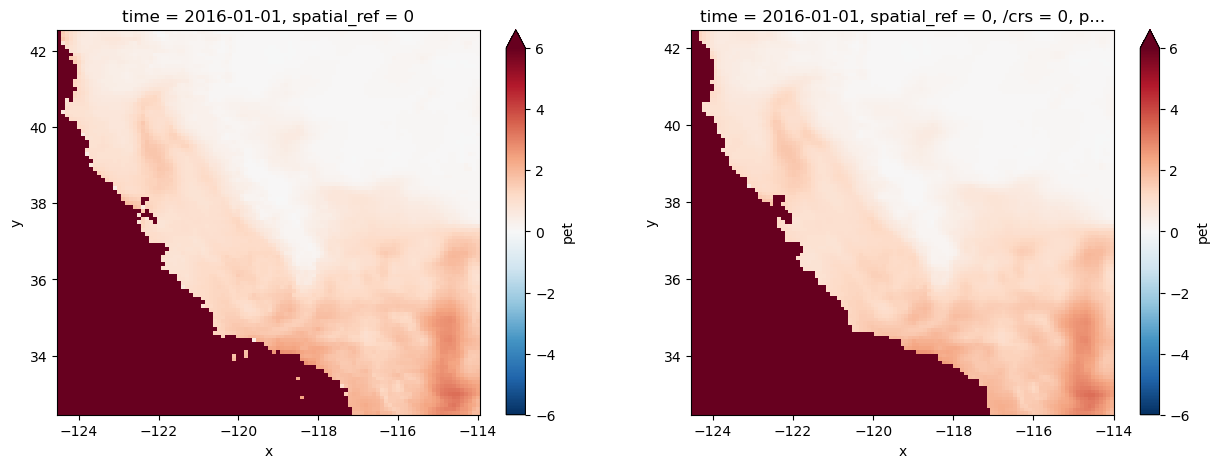

In [55]:
# Clip to California
ds_PET = ds_PET.rename({'latitude': 'y', 'longitude':'x'})
ds_PET = ds_PET.sel(x=slice(minx, maxx), y=slice(maxy, miny)).copy()

# Interpolate to SMAP grid
ds_PET.rio.write_crs('epsg:4326', inplace=True)
PET_resampled = ds_PET['pet'].interp(coords={'x': ds_SMAPL3['x'], 'y': ds_SMAPL3['y']}, method='linear', kwargs={'fill_value': np.nan})
ds_SMAPL3['PET'] = PET_resampled

# Plot
if plot_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ds_PET.pet.sel(time='2016-01-01').plot(vmax=6, ax=ax1)
    PET_resampled.sel(time='2016-01-01').plot(vmax=6, ax=ax2)

# See: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp.html
# If I have to reproject, see: https://github.com/corteva/rioxarray/issues/119

## Processing data

### Get daily mean values

In [16]:
# SMAP L4
ds_SMAPL4 = ds_SMAPL4_3hrly.precipitation_total_surface_flux.resample(time='D', skipna=True, keep_attrs=True).mean('time')
ds_SMAPL4.rio.write_crs('epsg:4326', inplace=True)
ds_SMAPL4 = ds_SMAPL4.sel(band=1).rio.reproject_match(ds_SMAPL3)

# SMAP L3
# Mask low-quality data
ds_SMAPL3['soil_moisture_am_masked'] = ds_SMAPL3.soil_moisture.where((ds_SMAPL3.retrieval_qual_flag == 0) | (ds_SMAPL3.retrieval_qual_flag == 8))
ds_SMAPL3['soil_moisture_pm_masked'] = ds_SMAPL3.soil_moisture_pm.where((ds_SMAPL3.retrieval_qual_flag_pm == 0) | (ds_SMAPL3.retrieval_qual_flag_pm == 8))
stacked_data = ds_SMAPL3[['soil_moisture_am_masked', 'soil_moisture_pm_masked']].to_array(dim='new_dim')
ds_SMAPL3['soil_moisture_daily'] = stacked_data.mean(skipna=True, dim="new_dim")

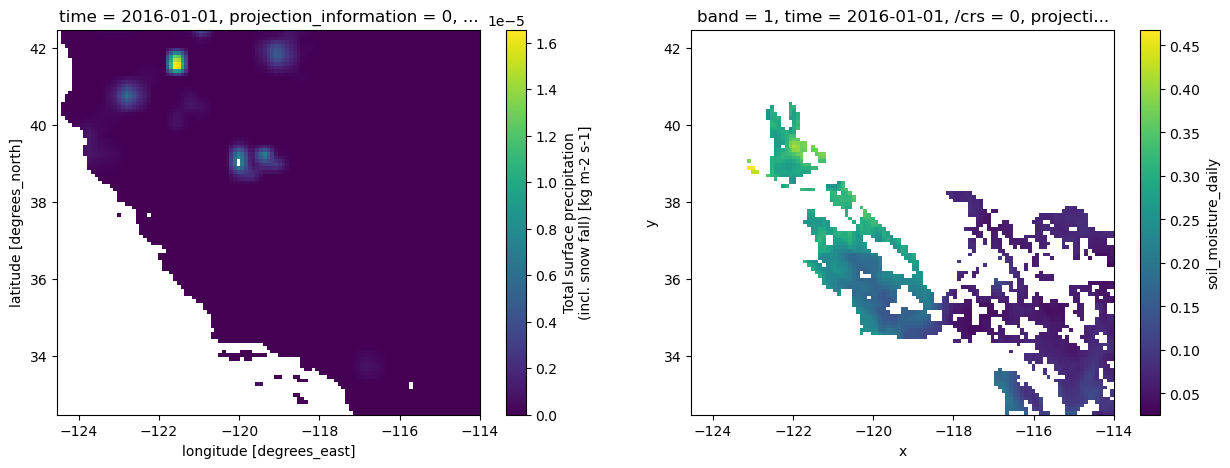

In [71]:
if plot_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ds_SMAPL4.sel(time='2016-01-01').plot(ax=ax1)
    ds_SMAPL3.soil_moisture_daily.sel(time='2016-01-01').plot(ax=ax2)

### Calculate dS/dt

In [20]:
# Mask by precipitation
# https://geohackweek.github.io/nDarrays/09-masking/
precip_mask = ds_SMAPL4.where(ds_SMAPL4 < precip_thresh)

# Insert dummy soil moisture record where (precipitation is present) && (soil moisture record does not exist)
# In this case, drydown pattern is disrupted and shouldn't be calculated. 
# So I put extremely large values for those records, calculate dS, and drop the dS afterwards
no_sm_record_but_precip_present = ds_SMAPL4.where((precip_mask.isnull()) & (ds_SMAPL3['soil_moisture_daily'].isnull()))
ds_SMAPL3['sm_for_dS_calc'] = ds_SMAPL3['soil_moisture_daily'].where(no_sm_record_but_precip_present.isnull(), 9999)

# print(precip_mask.sel(x=sample_x, y=sample_y, method='nearest').values.T)
# print(ds_SMAPL3['soil_moisture_daily'].sel(x=sample_x, y=sample_y, method='nearest').values.T)
# print(no_sm_record_but_precip_present.sel(x=sample_x, y=sample_y, method='nearest').values.T)
# print(sm_for_dS_calc.sel(x=sample_x, y=sample_y, method='nearest').values.T)

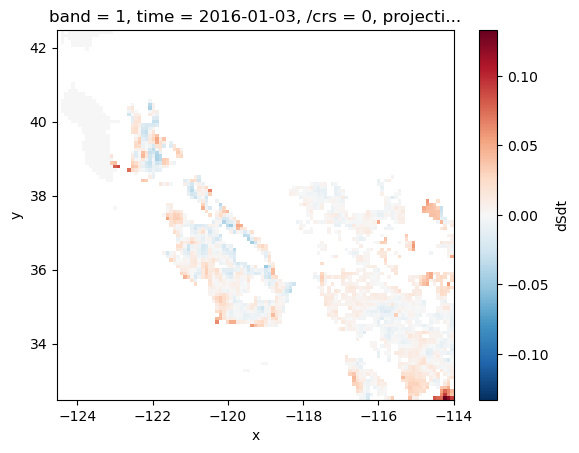

In [21]:
# Calculate dS
ds_SMAPL3['dS'] = ds_SMAPL3['sm_for_dS_calc'].bfill(dim="time", limit=5).diff(dim="time").where(ds_SMAPL3['sm_for_dS_calc'].notnull().shift(time=+1))

# Drop the dS where  (precipitation is present) && (soil moisture record does not exist)
ds_SMAPL3['dS'] = ds_SMAPL3['dS'].where((ds_SMAPL3['dS'] > -1) & (ds_SMAPL3['dS'] < 1))

# Calculate dt
non_nulls = ds_SMAPL3['sm_for_dS_calc'].isnull().cumsum(dim='time')
nan_length = non_nulls.where(ds_SMAPL3['sm_for_dS_calc'].notnull()).bfill(dim="time")+1 - non_nulls +1
ds_SMAPL3['dt'] = nan_length.where(ds_SMAPL3['sm_for_dS_calc'].isnull()).fillna(1)

# Calculate dS/dt
ds_SMAPL3['dSdt'] = ds_SMAPL3['dS']/ds_SMAPL3['dt']
ds_SMAPL3['dSdt'] = ds_SMAPL3['dSdt'].shift(time=-1)

if plot_results:
    ds_SMAPL3['dSdt'].sel(time='2016-01-03').plot()

In [101]:
# Mask where precipitation is on the day 1 of soil moisture measruement
ds_SMAPL3['dSdt'] = ds_SMAPL3['dSdt'].where(precip_mask.notnull())

# print(ds_SMAPL3['dSdt'].sel(x=sample_x, y=sample_y, method='nearest').values.T)
# print(ds_SMAPL3_masked.sel(x=sample_x, y=sample_y, method='nearest').values.T)
# print(test.sel(x=sample_x, y=sample_y, method='nearest').values)

if plot_results:
    sample_x = -114
    sample_y = 34
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    ds_SMAPL3['soil_moisture_daily'].sel(x=sample_x, y=sample_y, method='nearest').interp(method='linear').plot.scatter(ax=ax1)
    ds_SMAPL3['dSdt'].sel(x=sample_x, y=sample_y, method='nearest').interp(method='linear').plot.scatter(ax=ax2)
    ds_SMAPL4.sel(x=sample_x, y=sample_y, method='nearest').plot.scatter(ax=ax3)

TypeError: unsupported operand type(s) for &: 'float' and 'Array'

## Fit regression b/w dS/dt & S for upper/lower PET quantile

### Get upper/lower PET quantile

In [102]:
# Get PET quantile values 
ds_SMAPL3['PET'] = ds_SMAPL3['PET'].chunk({'time': len(ds_SMAPL3['PET'].time), 'x': 'auto', 'y': 'auto'})
ds_quantile = ds_SMAPL3['PET'].where(precip_mask.notnull()).quantile(dim="time", q=[lower_quantile_thresh, upper_quantile_thresh])

if plot_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ds_quantile.sel(quantile=lower_quantile_thresh).plot(ax=ax1, vmax=6)
    ds_quantile.sel(quantile=upper_quantile_thresh).plot(ax=ax2, vmax=6)

ValueError: dimension time on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.chunk(dict(time=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

In [82]:
ds_SMAPL3['PET_upper_mask'] = ds_SMAPL3['PET'].where(ds_SMAPL3['PET'] >= ds_quantile.sel(quantile=upper_quantile_thresh))
ds_SMAPL3['PET_lower_mask'] = ds_SMAPL3['PET'].where(ds_SMAPL3['PET'] <= ds_quantile.sel(quantile=lower_quantile_thresh))

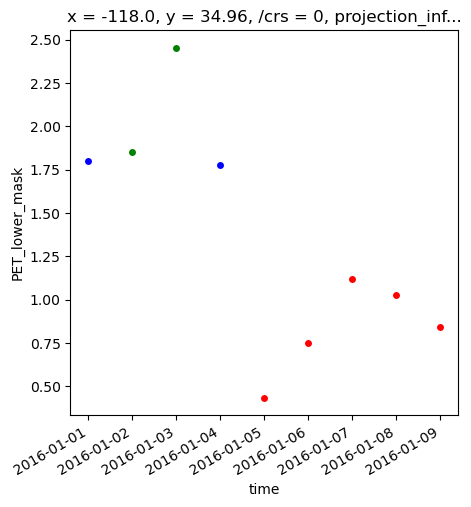

In [83]:
if plot_results:
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    ds_SMAPL3['PET'].sel(x=sample_x, y=sample_y, method='nearest').plot.scatter(ax=ax1, color='blue')
    ds_SMAPL3['PET_upper_mask'].sel(x=sample_x, y=sample_y, method='nearest').plot.scatter(ax=ax1, color='green')
    ds_SMAPL3['PET_lower_mask'].sel(x=sample_x, y=sample_y, method='nearest').plot.scatter(ax=ax1, color='red')

### Fit regression line

In [125]:
# Get the minimum soil mositure values over the observation period for a given pixel
sm_min = ds_SMAPL3.soil_moisture_daily.min(dim="time")

In [126]:
# Shift x values 
ds_SMAPL3['shifted_sm'] = ds_SMAPL3.soil_moisture_daily - sm_min
ds_SMAPL3['neg_dSdt'] = ds_SMAPL3['dSdt'] * (-1)
input_sm_upper = ds_SMAPL3.where((ds_SMAPL3['PET_upper_mask'].notnull()) & (ds_SMAPL3['neg_dSdt'] > 0))
input_sm_lower = ds_SMAPL3.where((ds_SMAPL3['PET_lower_mask'].notnull()) & (ds_SMAPL3['neg_dSdt'] > 0))

if plot_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ds_SMAPL3.soil_moisture_daily.sel(x=sample_x, y=sample_y, method='nearest').interp(method='linear').plot(ax=ax1)
    ds_SMAPL3.shifted_sm.sel(x=sample_x, y=sample_y, method='nearest').interp(method='linear').plot(ax=ax2)
    print(sm_min.sel(x=sample_x, y=sample_y, method='nearest').values)

if plot_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    input_sm_upper.sel(time='2016-01-01').plot(ax=ax1)
    input_sm_lower.sel(time='2016-01-01').plot(ax=ax2)

SyntaxError: expected ':' (4084706861.py, line 14)

In [108]:
def fit_regression_through_origin(input_sm):

    # Fit regression of linear line through the origin
    # the slope a is calculated is: a = sum(xi * yi) / sum((xi)^2)
    # Proofs in: 
    # https://onlinelibrary.wiley.com/doi/10.1111/1467-9639.00136
    # http://sites.msudenver.edu/ngrevsta/wp-content/uploads/sites/416/2020/02/Notes_07.pdf
    # https://www.jstor.org/stable/2527698?seq=2

    numerator = input_sm.shifted_sm * input_sm.neg_dSdt
    denominator = input_sm.shifted_sm * input_sm.shifted_sm
    denominator_masked = denominator.where((~numerator.isnull()))
    a = numerator.sum(dim="time", skipna=True) / denominator_masked.sum(dim="time", skipna=True)

    # Calculate error metrics 

    # https://web.ist.utl.pt/~ist11038/compute/errtheory/,regression/regrthroughorigin.pdf
    # R2 = sum(Yi_modeled^2)/sum(Yi_observed^2)

    # https://rpubs.com/aaronsc32/regression-through-the-origin
    # http://sites.msudenver.edu/ngrevsta/wp-content/uploads/sites/416/2020/02/Notes_07.pdf
    # SSE = sum(Yi_obs ^2) - a_i^2 * sum(xi_obs^2)
    # MSE = SSE/ (n-1)

    y2 =  ds_SMAPL3.neg_dSdt *  ds_SMAPL3.neg_dSdt
    n = denominator.where(~numerator.isnull()).time.shape[0]
    SSE = y2.where((~numerator.isnull())).sum(dim="time", skipna=True) - a * denominator_masked.sum(dim="time", skipna=True)
    MSE = SSE / (n-1)
    
    # https://pubs.cif-ifc.org/doi/pdf/10.5558/tfc71326-3
    # https://dynamicecology.wordpress.com/2017/04/13/dont-force-your-regression-through-zero-just-because-you-know-the-true-intercept-has-to-be-zero/

    return a, MSE


In [109]:
a_upper, MSE_upper = fit_regression_through_origin(input_sm_upper)
a_lower, MSE_lower = fit_regression_through_origin(input_sm_lower)

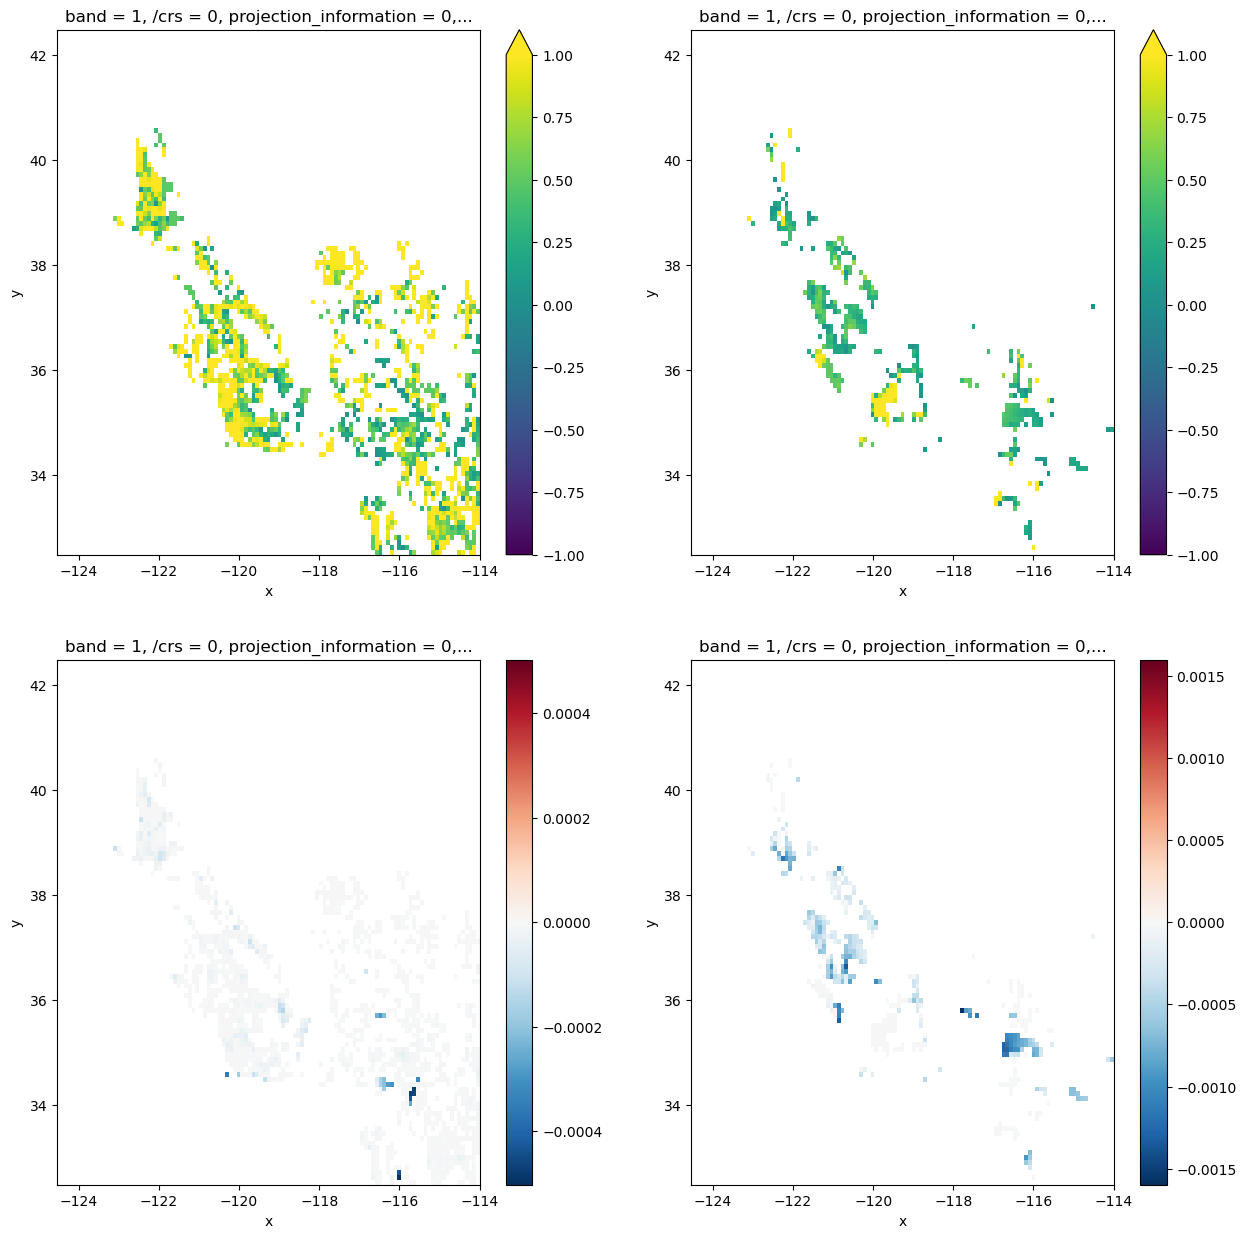

In [110]:
if plot_results:
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    a_upper.sel(band=1).plot(ax=ax1, vmin=-1, vmax=1)
    a_lower.sel(band=1).plot(ax=ax2, vmin=-1, vmax=1)
    MSE_upper.sel(band=1).plot(ax=ax3)
    MSE_lower.sel(band=1).plot(ax=ax4)

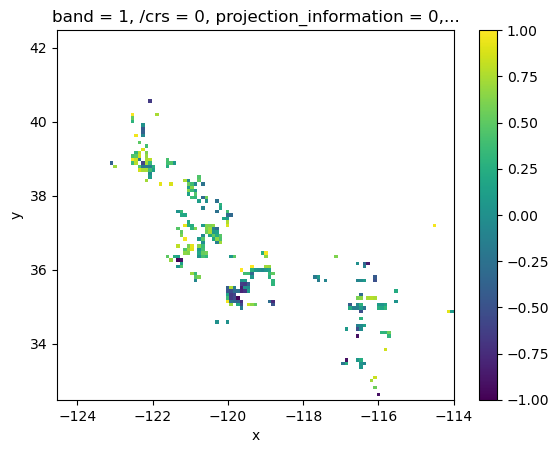

In [111]:
a_diff = a_upper - a_lower
if plot_results:
    a_diff.plot(vmin=-1, vmax=1)

[0.1712994]


[[0.03325027 0.01449054 0.         0.01265042 0.00768009        nan
         nan        nan        nan]]
[[ 0.01875973  0.01449054 -0.01265042  0.00497033         nan         nan
          nan         nan         nan]]
[[ 0.01875973  0.01449054 -0.01265042  0.00497033         nan         nan
          nan         nan         nan]]
[0.14925972]
[0.56419772]
[0.39289831]


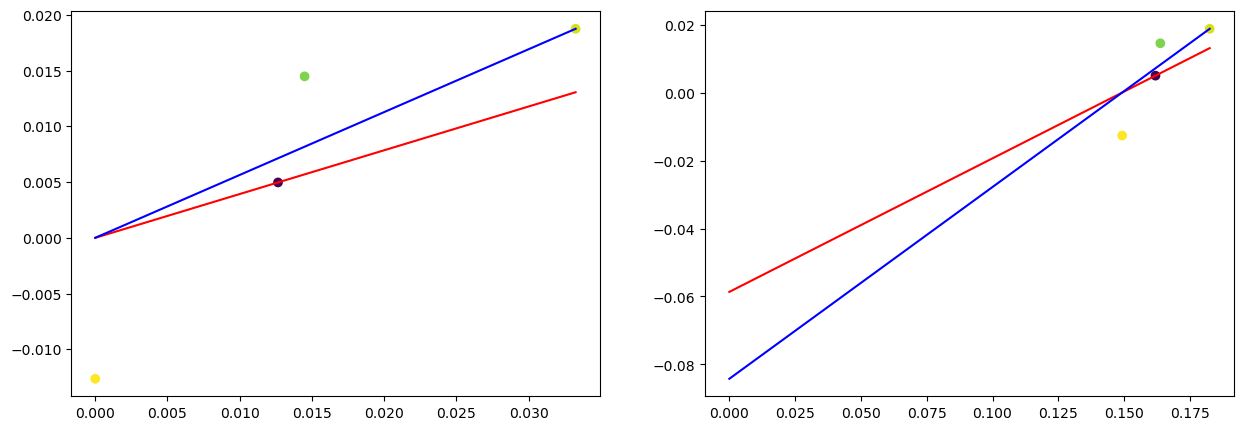

In [116]:
# Plot 
sample_x = -120
sample_y = 35.3
S = ds_SMAPL3.shifted_sm.sel(x=sample_x, y=sample_y, method='nearest').values
dSdt = ds_SMAPL3.neg_dSdt.sel(x=sample_x, y=sample_y, method='nearest').values
PET = ds_SMAPL3.PET.sel(x=sample_x, y=sample_y, method='nearest').values
S_min = sm_min.sel(x=sample_x, y=sample_y, method='nearest').values
a_upper_sel = a_upper.sel(x=sample_x, y=sample_y, method='nearest').values
a_lower_sel = a_lower.sel(x=sample_x, y=sample_y, method='nearest').values
a_diff_sel = a_diff.sel(x=sample_x, y=sample_y, method='nearest').values

print(S.T)
print(dSdt.T)
print(dSdt.T)
print(S_min)
print(a_upper_sel)
print(a_lower_sel)
print(a_diff_sel)


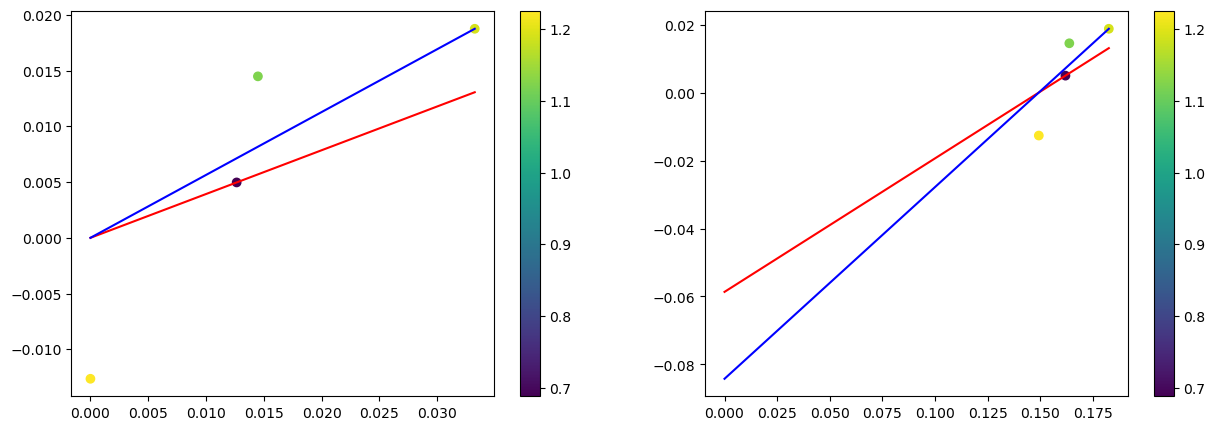

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sc1 = ax1.scatter(S, dSdt, c=PET)
plt.colorbar(sc1)
x = np.linspace(0, np.nanmax(S),100)
y_lower = a_lower_sel*x # (x+S_min)
y_upper = a_upper_sel*x
ax1.plot(x, y_lower, '-r')
ax1.plot(x, y_upper, '-b')

sc = ax2.scatter(S+S_min, dSdt, c=PET)
plt.colorbar(sc)
x = np.linspace(0, np.nanmax(S+S_min),100)
y_lower = a_lower_sel*x - a_lower_sel*S_min 
y_upper = a_upper_sel*x - a_upper_sel*S_min 
ax2.plot(x, y_lower, '-r')
ax2.plot(x, y_upper, '-b')